# What are the most demanded skills for the top 3 most popular data roles?

### Methodology

1. Clean-up skill column
2. Calculate skill count based on ``job_title_short``
3. Plot initial findings
4. Calculate skill percentage
5. Plot initial findings

In [1]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

## Filter Data for the EU

In [2]:
# Define list of EU countries
EU_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']

df_EU = df[(df['job_country'].isin(EU_countries))]

## Explode SKills

Converts the ``job_skills`` column from string representations of lists into actual list objects and then expands these lists so each skill appears in its own row. It then displays the ``job_title`` and ``job_skills`` columns, allowing us to analyze the distribution of skills across different data job titles.

In [3]:
df_skills = df_EU.explode('job_skills')

df_skills[['job_title', 'job_skills']]

,job_title,job_skills
2,"Data Engineer/Scientist/Analyst, Mid or Senior...",python
2,"Data Engineer/Scientist/Analyst, Mid or Senior...",sql
2,"Data Engineer/Scientist/Analyst, Mid or Senior...",c#
2,"Data Engineer/Scientist/Analyst, Mid or Senior...",azure
2,"Data Engineer/Scientist/Analyst, Mid or Senior...",airflow
...,...,...
785735,Senior Data Engineer,docker
785737,CRM Data Analyst,sas
785737,CRM Data Analyst,sas
785737,CRM Data Analyst,sql


## Count Skills per Job Title 

Groups DataFrame by ``job_skills`` and ``job_title_short``, counting the occurrences of each skill within each job title. Then resets the index of the Series to turn it back into a DataFrame and renames the series holding the count to 'count'. The final DataFrame, ``df_skills_count``, shows the frequency of each skill with each job title.

In [4]:
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

df_skills_count = df_skills_count.reset_index(name='skill_count')

df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
1325,python,Data Engineer,31556
1644,sql,Data Engineer,30687
1326,python,Data Scientist,28391
1643,sql,Data Analyst,25529
132,azure,Data Engineer,19633
...,...,...,...
964,mlr,Data Analyst,1
963,mlr,Cloud Engineer,1
1193,pascal,Senior Data Analyst,1
42,angular.js,Senior Data Engineer,1


## Create List of Top 3 Roles

In [5]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

## Plot Skill Counts

Creates a stacked horizontal bar chart for the top 5 skills for Top 3 roles, displaying the frequency of each skill.

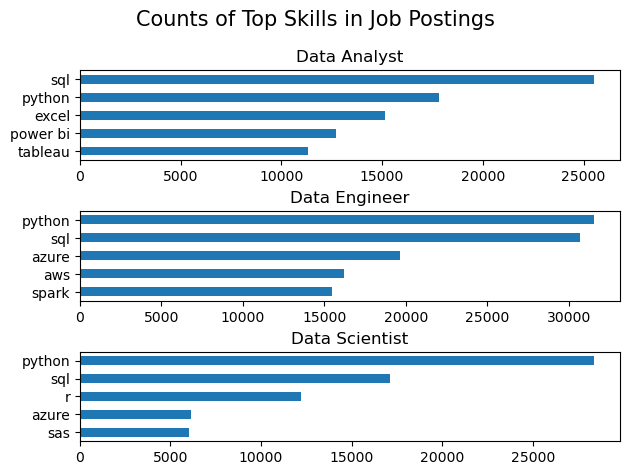

In [6]:
fig, ax = plt.subplots(len(job_titles), 1)

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)
    df_plot.plot(kind='barh', x='job_skills', y='skill_count', ax=ax[i], title=job_title)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].legend().set_visible(False)

fig.suptitle('Counts of Top Skills in Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5)
plt.show()

## Convert Counts to Percentages

#### Focus: Counts don't show what portions of jobs are requesting these skills

So we'll convert the counts into percentages which helps us understand how each job title represents relative to the entire dataset.

Before we can calculate the percentages we need the total counts for the jobs posted by job title. Calculate the frequency of each job title using the ``value_counts()`` method on the ``job_title_short`` column. Then reset the index to transform the Series into a DataFrame and renames the columns to ``job_title_short`` and total. The DataFrame ``df_job_title_count`` now holds a list of job titles alongside their total occurrences.

In [10]:
df_job_title_count = df_EU['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count

,job_title_short,jobs_total
0,Data Analyst,57213
1,Data Engineer,56416
2,Data Scientist,45074
3,Software Engineer,15575
4,Business Analyst,14197
5,Senior Data Engineer,11740
6,Senior Data Scientist,8994
7,Senior Data Analyst,6594
8,Machine Learning Engineer,5048
9,Cloud Engineer,4683


Then we calculate the percentages. First merge ``df_skills_count`` and ``df_job_title_count``, based on the 'job_title_short' column, ensuring each skill count is associated with the total number of job postings for that title. Then calculate the percentage of each skill within its job title by dividing the skill count by the total job postings and multiplying by 100, adding this new data as a 'percentage' column.

In [8]:
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, how='left', on='job_title_short')

df_skills_perc['skill_percent'] = 100 * df_skills_perc['skill_count'] / df_skills_perc['jobs_total']

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,python,Data Engineer,31556,56416,55.934487
1,sql,Data Engineer,30687,56416,54.394144
2,python,Data Scientist,28391,45074,62.987532
3,sql,Data Analyst,25529,57213,44.620978
4,azure,Data Engineer,19633,56416,34.800411
...,...,...,...,...,...
2030,mlr,Data Analyst,1,57213,0.001748
2031,mlr,Cloud Engineer,1,4683,0.021354
2032,pascal,Senior Data Analyst,1,6594,0.015165
2033,angular.js,Senior Data Engineer,1,11740,0.008518


## Plot Percentage Count

Filters and sorts a DataFrame to get the top 5 skills percentages for these top 3 roles. After sorting the skills by descending percentage, reverse the order of these top 5 entries to use in a horizontal bar plot, which by default starts plotting from the bottom.

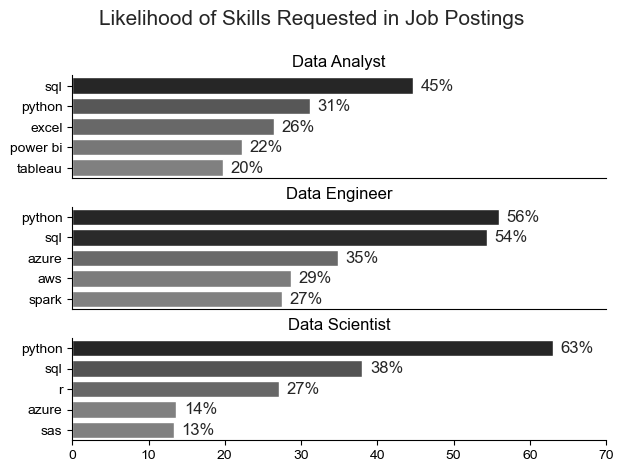

In [9]:
fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:grey_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 70)

    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center')

    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

sns.despine()
fig.suptitle('Likelihood of Skills Requested in Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5)
plt.show()